In [ ]:
!git clone https://github.com/JurjiuDarius/Segmentation-of-Teeth-in-Panoramic-X-ray-Image.git

Cloning into 'Segmentation-of-Teeth-in-Panoramic-X-ray-Image'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 222 (delta 11), reused 10 (delta 3), pack-reused 196
Receiving objects: 100% (222/222), 28.38 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net")
%cd /content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image
%mkdir /content/Data
%cp /content/drive/MyDrive/DentalPanoramicXrays.zip /content/Data

/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image


In [ ]:
from process_zip import process_zip
import os
path = "/content/Data"
process_zip(path)

In [ ]:
from images_prepare import *
from masks_prepare import *

X,X_sizes=pre_images((512,512),path,True)


Y=pre_splitted_masks(path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Custom_Masks')

X=np.float32(X/255)
Y=np.float32(Y/255)

x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

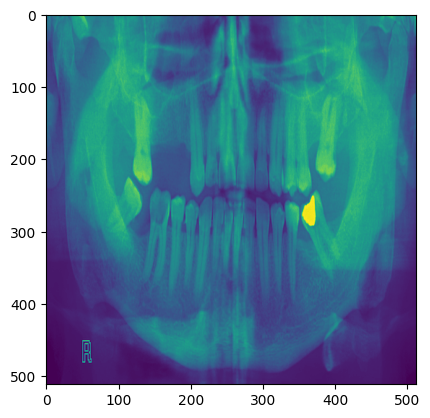

In [ ]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)

plt.imshow(x_train[19,:,:,0])


In [ ]:
import cv2
import numpy as np
from imutils import perspective
from scipy.spatial import distance as dist
from tqdm import tqdm
import json

def extract_bboxes(
     predict_image, erode_iteration, open_iteration, grayscale_required=False
):
    kernel1 = np.ones((5, 5), dtype=np.float32)
    kernel_sharpening = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = predict_image
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel1, iterations=open_iteration)
    image = cv2.filter2D(image, -1, kernel_sharpening)
    image = cv2.erode(image, kernel1, iterations=erode_iteration)
    if grayscale_required:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    labels = cv2.connectedComponents(thresh, connectivity=8)[1]

    unique_labels = np.unique(labels)
    count2 = 0
    boxes = []
    for label in unique_labels:
        if label == 0:
            continue

        # Create a mask
        mask = np.zeros(thresh.shape, dtype="uint8")
        mask[labels == label] = 255
        # Find contours and determine contour area
        cnts, hieararch = cv2.findContours(
            mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        cnts = cnts[0]
        c_area = cv2.contourArea(cnts)
        # threshhold for tooth count
        if c_area > 2000:
            count2 += 1

        (x, y), radius = cv2.minEnclosingCircle(cnts)
        rect = cv2.minAreaRect(cnts)
        box = cv2.boxPoints(rect)
        box = np.array(box, dtype="int")
        box = perspective.order_points(box)
        boxes.append(box)
    return boxes

PATH_TO_SAVE="/content/drive/MyDrive/DentalImages/BoundingBoxes/"

for index in tqdm(range(len(Y))):
  mask = (255*Y[index,:,:,0]).astype('uint8')
  mask = cv2.resize(
              mask,
              (1720, 1280),
              interpolation=cv2.INTER_LANCZOS4,
          )
  bboxes = extract_bboxes( mask, 3,2)
  bboxes = [bbox.tolist() for bbox in bboxes]
  file_path = f"{PATH_TO_SAVE}{index+1}.json"
  with open(file_path,"w") as json_file:
    json.dump(bboxes,json_file)





100%|██████████| 116/116 [00:22<00:00,  5.14it/s]
